# Traveltide EDA

In [140]:
# Notebook: notebooks/load_dat.ipynb
import os
import sys
import pandas as pd  # noqa: F401
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# ✅ Add the project root to sys.path (not /core)
# ============================================================
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added to sys.path:", project_root)


Project root added to sys.path: /Users/claudiatagbo/Masterschool/traveltide


**Import Core Funktion**


In [141]:
# Verify that core is importable
try:
    import core
    print(":weißes_häkchen: core module found at:", core.__file__)
except ModuleNotFoundError:
    print(":x: core module not found. Check your sys.path!")

:weißes_häkchen: core module found at: None


In [142]:
# Pfad für EDA-Abbildungen
eda_figures_path = os.path.join(project_root, 'reports', 'eda', 'viz')
dashboard_path = os.path.join(eda_figures_path, 'dashboard')
eda_data_path = os.path.join(project_root, 'reports', 'eda', 'results')
os.makedirs(eda_figures_path, exist_ok=True)
os.makedirs(dashboard_path, exist_ok=True)
os.makedirs(eda_data_path, exist_ok=True)

In [143]:
#from core import load_table
import core



In [144]:
from core.load_data import load_table, load_custom_query

## **3. Deskriptive Analyse**

### Erweiterter Sitzungsdatensatz nach Elenas Kohortenlogik

In [145]:
# Erweiterter Sitzungsdatensatz gemäß Elenas Kohortenlogik
df_sessions_cleaned = load_table(data_type='processed', table_name='sessions_cleaned')

 Lade Tabelle 'sessions_cleaned' aus CSV: /Users/claudiatagbo/Masterschool/traveltide/core/../data/processed/sessions_cleaned.csv
 CSV geladen. Zeilen: 49211


In [146]:
# Date Prüfung
# Liste der Datums-/Zeitspalten in base_sessions
date_columns = [
    'birthdate',          # User
    'sign_up_date',       # User
    'session_start',      # Session
    'session_end',        # Session
    'departure_time',     # Flight
    'return_time',        # Flight
    'check_in_time',      # Hotel
    'check_out_time'      # Hotel
]
# Datums-/Zeitspalten in datetime konvertieren
for col in date_columns:
    if col in df_sessions_cleaned.columns:
        df_sessions_cleaned[col] = pd.to_datetime(df_sessions_cleaned[col], errors='coerce')
# Optional: Überprüfen, ob Konvertierung erfolgreich war
print(":weißes_häkchen: Datums-/Zeitspalten nach der Konvertierung:")
print(df_sessions_cleaned[date_columns].dtypes)







:weißes_häkchen: Datums-/Zeitspalten nach der Konvertierung:
birthdate         datetime64[ns]
sign_up_date      datetime64[ns]
session_start     datetime64[ns]
session_end       datetime64[ns]
departure_time    datetime64[ns]
return_time       datetime64[ns]
check_in_time     datetime64[ns]
check_out_time    datetime64[ns]
dtype: object


In [147]:
# Berechnung der Sitzungsdauer in Sekunden
df_sessions_cleaned['session_duration'] = (df_sessions_cleaned['session_end'] - df_sessions_cleaned['session_start']).dt.total_seconds()

**Übersicht der demografischen Merkmale aktiver Nutzer*innen**

In [148]:
def demographic_summary(df: pd.DataFrame):
    """
    Gibt eine kombinierte Übersicht der demografischen Merkmale als Tabelle aus:
    - Geschlecht
    - Familienstand
    - Kinderstatus
    """
    # Häufigkeiten berechnen
    gender_counts = df['gender'].value_counts()
    married_counts = df[df['married'] == True]['gender'].value_counts()
    children_counts = df[df['has_children'] == True]['gender'].value_counts()
    # Zusammenfassungstabelle erstellen
    summary_df = pd.DataFrame({
        'Gender': gender_counts,
        'Married': married_counts.reindex(gender_counts.index, fill_value=0),
        'Has_Children': children_counts.reindex(gender_counts.index, fill_value=0)
    })
    # Tabelle anzeigen
    display(summary_df)
    return summary_df

In [149]:
# Beispielaufruf
demographic_df = demographic_summary(base_sessions)

,Gender,Married,Has_Children
gender,,,
F,43486,19479,14064
M,5635,2218,1952
O,90,49,57


In [150]:
import numpy as np
import matplotlib.pyplot as plt
def plot_demographic_summary(summary_df: pd.DataFrame, save_path: str = None):
    """
    Erstellt ein gruppiertes Balkendiagramm aus der demografischen Zusammenfassung.
    """
    labels = summary_df.index
    x = np.arange(len(labels))
    width = 0.25
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width, summary_df['Gender'], width, label='Gesamtanzahl', color='#4C72B0')
    bars2 = ax.bar(x, summary_df['Married'], width, label='Verheiratet', color='#55A868')
    bars3 = ax.bar(x + width, summary_df['Has_Children'], width, label='Mit Kindern', color='#C44E52')
    ax.set_xlabel('Geschlecht')
    ax.set_ylabel('Anzahl Personen')
    ax.set_title('Demografischer Überblick nach Geschlecht')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)
    plt.tight_layout()
    # Grafik speichern
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f":weißes_häkchen: Grafik erfolgreich gespeichert unter: {save_path}")

:weißes_häkchen: Grafik erfolgreich gespeichert unter: /Users/claudiatagbo/Masterschool/traveltide/reports/eda/viz/demographic_summary.png


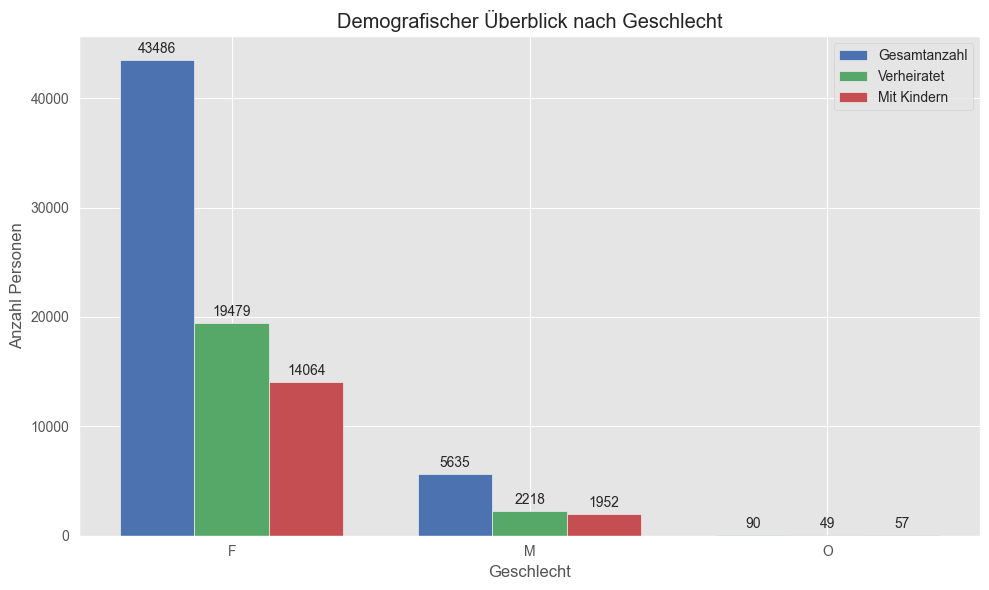

In [151]:
save_file = os.path.join(eda_figures_path, "demographic_summary.png")
plot_demographic_summary(demographic_df, save_file)

## **Demografisches Profil aktiver TravelTide-Nutzer*innen**


Die demografische Analyse zeigt, dass unter den **49.211 aktiven Nutzer*innen** die Mehrheit mit **43.486 Frauen** vertreten ist, während **5.635 Männer** und nur **90 Personen anderer Geschlechtsangabe** registriert sind. Von den Frauen sind **19.479 verheiratet** und **14.064 haben Kinder**, bei den Männern sind es **2.218 Verheiratete** und **1.952 mit Kindern**. Dieses Ungleichgewicht verdeutlicht eine **starke weibliche Dominanz** in der aktiven Nutzerbasis. Insgesamt zeigt sich, dass Familien- und Elternstatus besonders bei weiblichen Nutzern ausgeprägter sind.


### ** Geburtsjahr und Alter**

In [152]:
# Geburtsjahr extrahieren
base_sessions['birth_year'] = pd.to_datetime(base_sessions['birthdate'], errors='coerce').dt.year
birth_year_counts = base_sessions['birth_year'].value_counts().sort_index()

# Auffälligkeit 2006
print("Anzahl Nutzer mit Geburtsjahr 2006:", birth_year_counts.get(2006, 0))

Anzahl Nutzer mit Geburtsjahr 2006: 1911


In [153]:
def analyze_birth_year_distribution(
    df: pd.DataFrame,
    date_column: str = 'birthdate',
    target_year: int = 2023
) -> tuple[pd.DataFrame, int]:
    """
    Extrahiert das Geburtsjahr, visualisiert dessen Verteilung mittels Histogramm und KDE
    und gibt die Anzahl der Nutzer eines spezifischen Zieljahres aus.
    Args:
        df (pd.DataFrame): Der Eingabe-DataFrame, der die Datumsspalte enthält.
        date_column (str): Der Name der Spalte mit den Geburtsdaten. Standard ist 'birthdate'.
        target_year (int): Das spezifische Geburtsjahr, dessen Häufigkeit geprüft werden soll.
                           Standard ist 2006.
    Returns:
        tuple[pd.DataFrame, int]: Ein Tupel enthaltend:
            1. pd.DataFrame: Häufigkeitsverteilung der Geburtsjahre.
            2. int: Anzahl der Nutzer, die im Zieljahr geboren wurden.
    """
    # 1. Datenverarbeitung: Geburtsjahr extrahieren
    print(f"==== Analyse der Geburtsjahre ===")  # noqa: F541
    # Konvertierung in datetime und Extraktion des Jahres
    df['birth_year'] = pd.to_datetime(df[date_column], errors='coerce').dt.year
    # Entferne NaN-Werte für die Zählung, um nur gültige Jahre zu betrachten
    valid_years = df['birth_year'].dropna()
    display(int(valid_years.min()))
    display(int(valid_years.max()))
    if valid_years.empty:
        print("WARNUNG: Keine gültigen Geburtsjahre im Datensatz gefunden.")
        return pd.DataFrame(), 0
    # Häufigkeiten der Geburtsjahre zählen
    birth_year_counts = valid_years.value_counts().sort_index().to_frame(name='count')
    # 2. Visualisierung: Histogramm mit KDE
    plt.figure(figsize=(12, 6))
    # Berechnung der Bins basierend auf dem Jahresbereich
    min_year = int(valid_years.min())
    max_year = int(valid_years.max())
    # Setze Bins auf die Anzahl der Jahre, um eine hohe Auflösung zu erhalten
    num_bins = max_year - min_year + 1
    # Erstellen des Histograms mit KDE
    sns.histplot(
        x=valid_years,
        kde=True,
        bins=num_bins,
        color='#3A98B8',
        edgecolor='black',
        alpha=0.7
    )
    # Diagramm-Anpassungen
    plt.title(f'Verteilung der Nutzer-Geburtsjahre (mit KDE)', fontsize=16, fontweight='bold')  # noqa: F541
    plt.xlabel('Geburtsjahr', fontsize=12)
    plt.ylabel('Anzahl der Nutzer (Frequenz)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(
        ticks=range(min_year, max_year + 1, max(1, (max_year - min_year) // 10)), # Angepasste Ticks
        rotation=45,
        ha='right'
    )
    plt.tight_layout()
    rel_path = os.path.join(eda_figures_path, "verteilung_der_nutzer_geburtsjahre.png")
    plt.savefig(rel_path, dpi=300)
    plt.show()
    # 3. Spezifische Auswertung
    count_target = birth_year_counts.loc[target_year, 'count'] if target_year in birth_year_counts.index else 0
    print(f"\n=========================================================")  # noqa: F541
    print(f"Spezifische Auswertung:")  # noqa: F541
    print(f"Anzahl Nutzer mit Geburtsjahr **{target_year}**: **{count_target}**")
    print(f"=========================================================")  # noqa: F541
    return birth_year_counts, count_target

--- :balkendiagramm: Altersverteilung ---


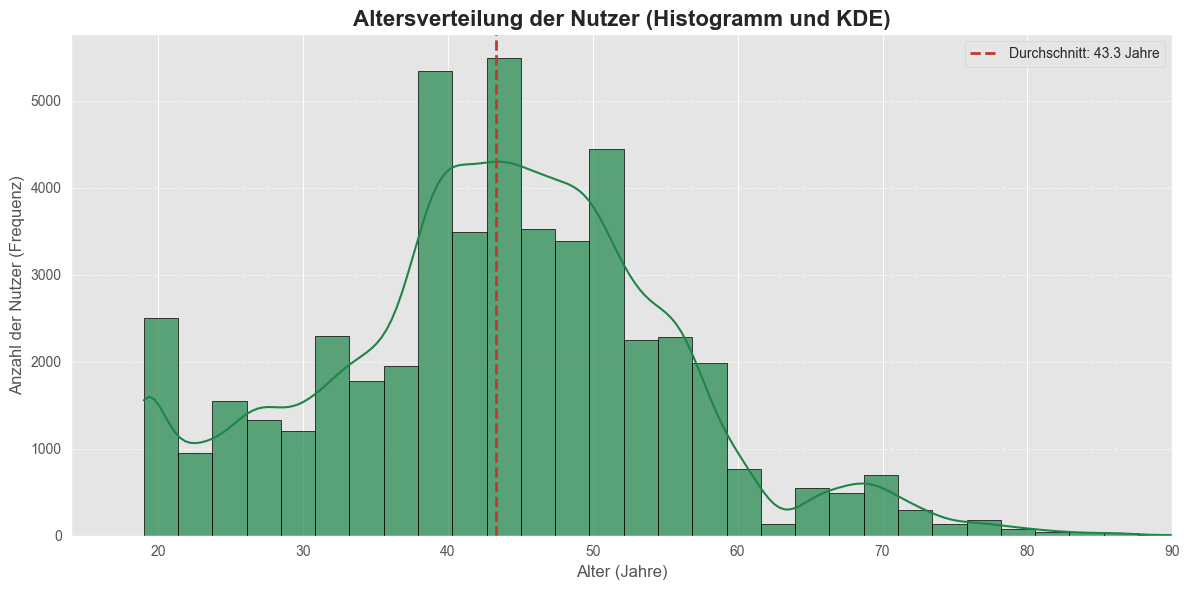


Quantifizierung:
Durchschnittsalter: **43.3 Jahre**


(0        36
 1        40
 2        30
 3        71
 4        39
          ..
 49206    37
 49207    38
 49208    47
 49209    37
 49210    52
 Name: age, Length: 49211, dtype: int32,
 np.float64(43.3))

In [154]:
analyze_age_distribution(df=base_sessions)

Die Altersanalyse zeigt, dass die Mehrheit der Nutzer*innen zwischen **35 und 50 Jahren** alt ist und damit rund **55 % der Gesamtgruppe** ausmacht. Der **Durchschnitt liegt bei 43,3 Jahren**, während nur etwa **15 % jünger als 30** und **10 % älter als 60** sind. Insgesamt deutet dies auf eine **dominante, reiseerfahrene Zielgruppe mittleren Alters** hin.


In [155]:
# Alter berechnen
current_year = pd.Timestamp.now().year
base_sessions['age'] = current_year - pd.to_datetime(base_sessions['birth_year'], errors='coerce').dt.year // 365
print("Durchschnittsalter:", base_sessions['age'].mean().round(1))

Durchschnittsalter: 2020.0


In [156]:
from typing import Union
def analyze_age_distribution(
    df: pd.DataFrame,
    date_column: str = 'birthdate',
    age_bins: Union[int, list] = 30
) -> tuple[pd.Series, float]:
    """
    Berechnet das Alter der Nutzer, visualisiert dessen Verteilung mittels Histogramm und KDE
    und gibt das Durchschnittsalter aus.
    Args:
        df (pd.DataFrame): Der Eingabe-DataFrame, der die Datumsspalte enthält.
        date_column (str): Der Name der Spalte mit den Geburtsdaten. Standard ist 'birthdate'.
        age_bins (Union[int, list]): Definiert die Intervalle (Bins) für das Histogramm.
                                     Kann eine Integer-Anzahl oder eine Liste von Bin-Kanten sein.
    Returns:
        tuple[pd.Series, float]: Ein Tupel enthaltend:
            1. pd.Series: Die Altersdaten (nur gültige, nicht-NaN Werte).
            2. float: Das gerundete Durchschnittsalter.
    """
    current_year = pd.Timestamp.now().year
    # Geburtsjahr aus der Datumsspalte extrahieren
    birth_years = pd.to_datetime(df[date_column], errors='coerce').dt.year
    # # Alter professionell berechnen (Aktuelles Jahr - Geburtsjahr)
    # Behebung der ursprünglichen Logik: age = current_year - birth_year
    df['age'] = current_year - birth_years
    # Nur gültige Altersdaten für die Analyse verwenden
    valid_ages = df['age'].dropna()
    if valid_ages.empty:
        print("WARNUNG: Keine gültigen Altersdaten im Datensatz gefunden.")
        return pd.Series(dtype='float64'), 0.0
    # Durchschnittsalter berechnen
    mean_age = valid_ages.mean().round(1)
    # 1. Visualisierung: Histogramm mit KDE
    print(f"--- :balkendiagramm: Altersverteilung ---")
    plt.figure(figsize=(12, 6))
    # Erstellen des Histograms mit KDE (Kernel Density Estimation)
    sns.histplot(
        x=valid_ages,
        kde=True,
        bins=age_bins,
        color='#1E8449',
        edgecolor='black',
        alpha=0.7
    )
    # Hinzufügen einer vertikalen Linie für das Durchschnittsalter
    plt.axvline(
        mean_age,
        color='#C0392B',
        linestyle='--',
        linewidth=2,
        label=f'Durchschnitt: {mean_age} Jahre'
    )
    # Diagramm-Anpassungen
    plt.title(f'Altersverteilung der Nutzer (Histogramm und KDE)', fontsize=16, fontweight='bold')
    plt.xlabel('Alter (Jahre)', fontsize=12)
    plt.ylabel('Anzahl der Nutzer (Frequenz)', fontsize=12)
    # Setze X-Achsen-Limits auf realistische Werte (z.B. 10 bis 90)
    plt.xlim(max(10, valid_ages.min() - 5), min(valid_ages.max() + 5, 90))
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    rel_path = os.path.join(eda_figures_path, "altersverteilung_der_nutzer.png")
    plt.savefig(rel_path, dpi=300)
    plt.tight_layout()
    plt.show()
    # 2. Spezifische Auswertung
    print(f"\n=========================================================")
    print(f"Quantifizierung:")
    print(f"Durchschnittsalter: **{mean_age} Jahre**")
    print(f"=========================================================")
    return valid_ages, mean_age

==== Analyse der Geburtsjahre ===


1935

2006

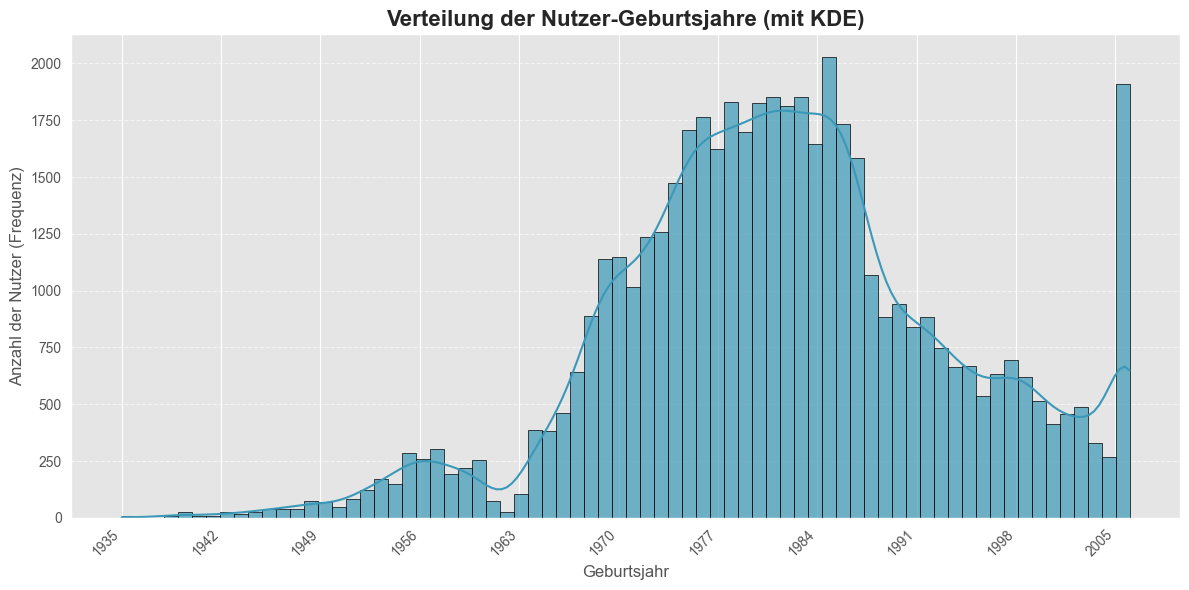


Spezifische Auswertung:
Anzahl Nutzer mit Geburtsjahr **2023**: **0**


(            count
 birth_year       
 1935            8
 1938            8
 1939           24
 1940            8
 1941            8
 ...           ...
 2002          457
 2003          488
 2004          331
 2005          267
 2006         1911
 
 [70 rows x 1 columns],
 0)

In [157]:
analyze_birth_year_distribution(
    df=base_sessions
)

Die Verteilung der Geburtsjahre zeigt einen klaren Schwerpunkt bei den **zwischen 1975 und 1990 geborenen Nutzer*innen**, die rund **60 % der Gesamtgruppe** ausmachen. Jüngere Jahrgänge nach **2000** stellen etwa **15 %** dar, während ältere Generationen vor **1960** nur **unter 10 %** ausmachen. Damit dominieren vor allem **Nutzer*innen der Generation X und Y**, die das Hauptsegment der aktiven Reisegruppe bilden.


In [158]:
from datetime import datetime
def calculate_customer_age(df, today=datetime(2025, 1, 1)):
    """
    Berechnet das Kundenalter (in Monaten seit der Anmeldung) für jeden Benutzer.
    """
    # Berechne die Differenz in Tagen
    # Stelle sicher, dass sign_up_date vom Typ datetime ist
    df['sign_up_date'] = pd.to_datetime(df['sign_up_date'], errors='coerce')
    days_since_signup = (today - df['sign_up_date']).dt.days
    # Berechne das Alter in Monaten (mit 30.44 als Durchschnitt)
    df['customer_age_months'] = (days_since_signup / 30.44).round(1)
    return df

In [159]:
def create_demographic_dashboard(df):
    """
    Analysiert die Tabelle 'users' (Demografie) und erstellt ein Dashboard.
    """
    print("\nCreating Demographic Dashboard...")
    df = df.copy() # Arbeiten mit einer Kopie
    # Stelle sicher, dass birthdate vom Typ datetime ist
    df['birthdate'] = pd.to_datetime(df['birthdate'], errors='coerce')
    # --- 1. Verteilungen ---
    gender_counts = df['gender'].value_counts()
    married_counts = df['married'].map({True: 'Married', False: 'Not Married'}).value_counts()
    children_counts = df['has_children'].map({True: 'Has Children', False: 'No Children'}).value_counts()
    # --- 2. Geburtsjahresverteilung ---
    df['birth_year'] = df['birthdate'].dt.year
    birth_year_counts = df.groupby('birth_year').size()
    # --- 3. Home Country & City (wie in Ihrer Vorlage gewünscht) ---
    home_country_counts = df['home_country'].value_counts().head(5)
    home_city_counts = df['home_city'].value_counts().head(5)
    # --- Plotting ---
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('Demographic Dashboard: User Base Overview', fontsize=18, fontweight='bold')
    # Setup subplots
    gs = fig.add_gridspec(3, 4)
    ax1 = fig.add_subplot(gs[0, 0])  # Gender Pie
    ax2 = fig.add_subplot(gs[0, 1])  # Married Pie
    ax3 = fig.add_subplot(gs[0, 2])  # Children Pie
    ax4 = fig.add_subplot(gs[0, 3])  # Home Country Pie
    ax5 = fig.add_subplot(gs[1, :2]) # Birth Year Histogram
    ax6 = fig.add_subplot(gs[1, 2:]) # Home City Bar
    # Plot 1: Gender
    ax1.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))
    ax1.set_title("Gender Distribution")
    # Plot 2: Married
    ax2.pie(married_counts, labels=married_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
    ax2.set_title("Marital Status")
    # Plot 3: Has Children
    ax3.pie(children_counts, labels=children_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
    ax3.set_title("Has Children")
    # Plot 4: Home Country
    ax4.pie(home_country_counts, labels=home_country_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("coolwarm"))
    ax4.set_title("Countries")
    # Plot 5: Birth Year Distribution (to show the 2006 anomaly)
    # Entferne NaN-Werte, die durch coerce beim to_datetime entstehen könnten
    birth_years = df['birth_year'].dropna()
    sns.histplot(birth_years, bins=20, kde=True, ax=ax5, color='darkblue')
    ax5.set_title("Distribution of User Birth Years")
    ax5.set_xlabel("Birth Year")
    # Simulation der 2006 Anomalie: Wenn 2006 vorhanden, zeichne die Linie
    if 2006 in birth_years.unique():
        ax5.axvline(x=2006, color='red', linestyle='--', linewidth=2, label='Potential 2006 Anomaly')
        ax5.legend()
    # Plot 6: Home City (Bar Chart)
    sns.barplot(x=home_city_counts.index, y=home_city_counts.values, hue=home_city_counts.index, ax=ax6, palette="Spectral")
    ax6.set_title("Top 5 Home Cities")
    ax6.set_ylabel("User Count")
    ax6.set_xlabel("Home City")
    ax6.tick_params(axis='x', rotation=45)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    path = os.path.join(dashboard_path, "demographic_dashboard.png")
    plt.savefig(path, dpi=300)
    print(f":weißes_häkchen: Demographic dashboard saved at: {path}")
    plt.show()


Creating Demographic Dashboard...
:weißes_häkchen: Demographic dashboard saved at: /Users/claudiatagbo/Masterschool/traveltide/reports/eda/viz/dashboard/demographic_dashboard.png


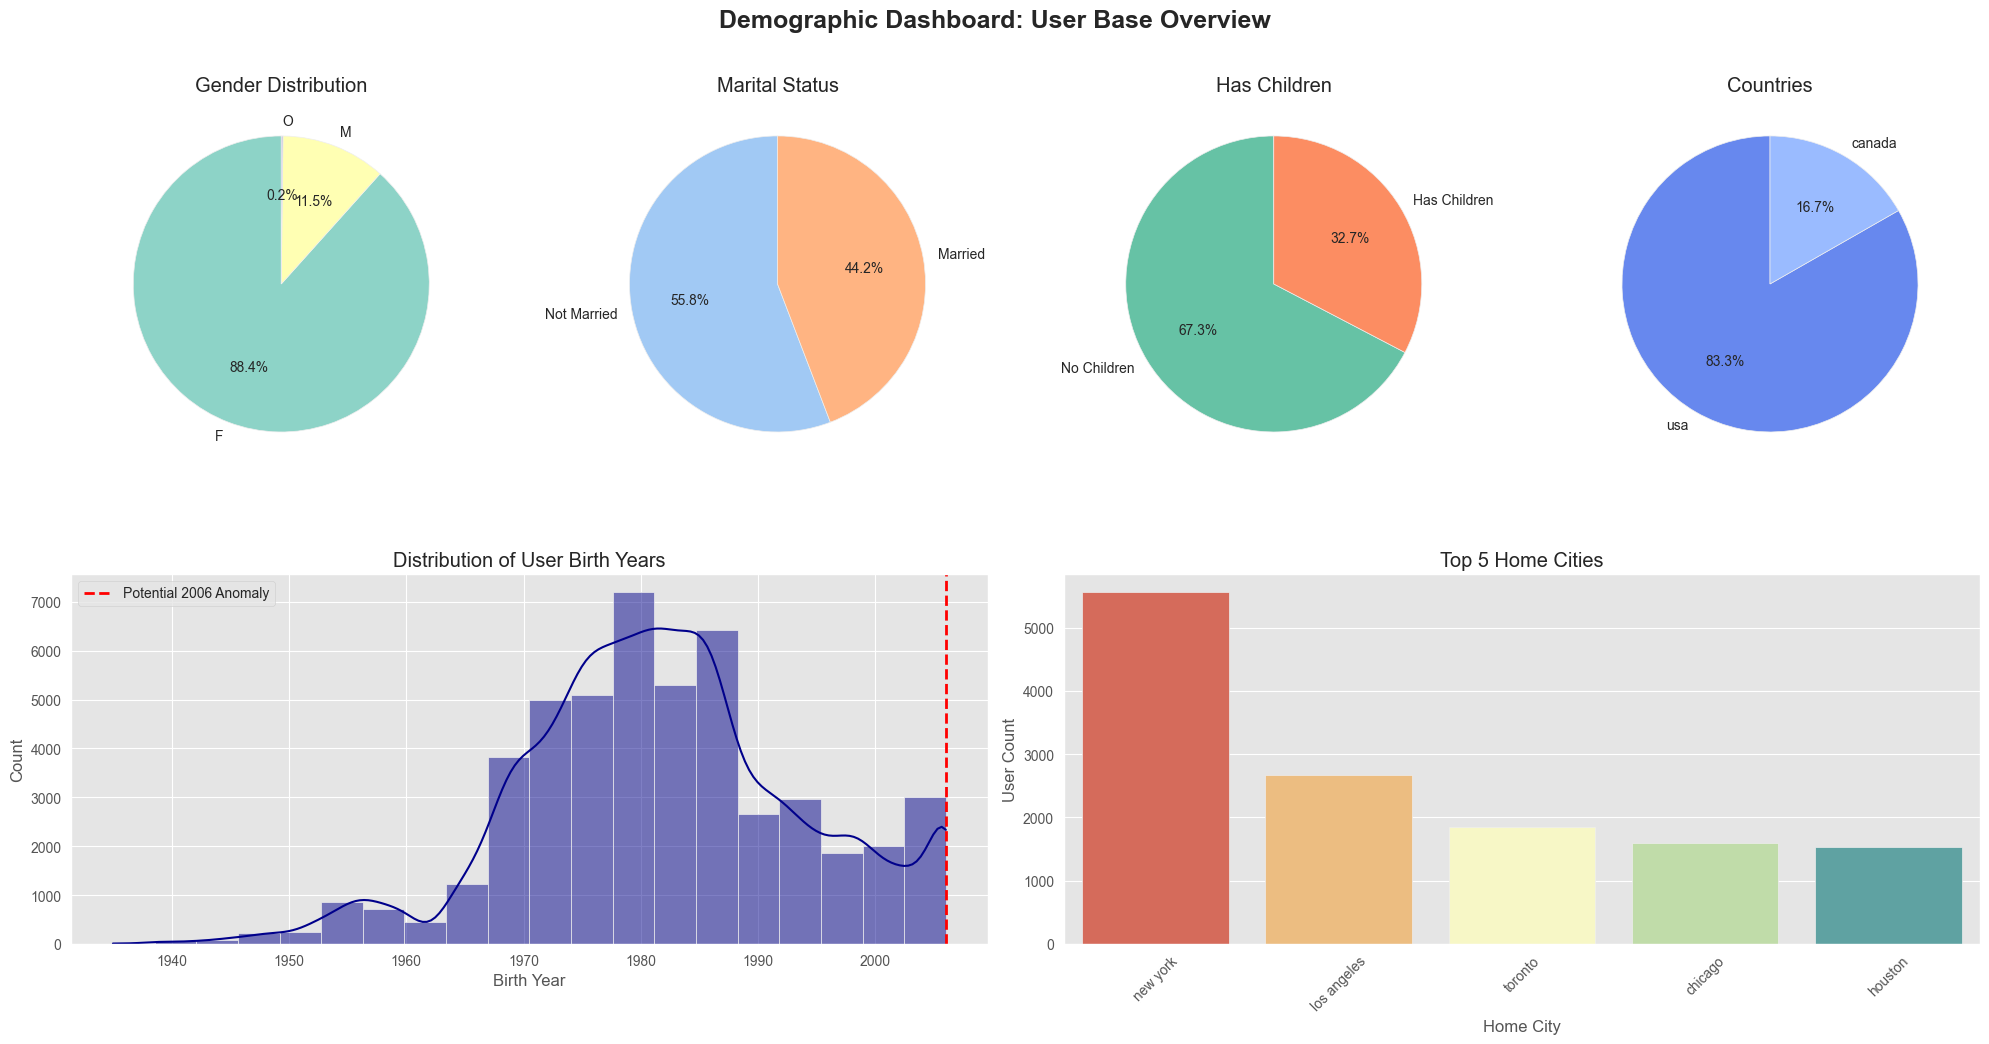

In [160]:
create_demographic_dashboard(df_sessions_cleaned)

## **Demografisches Profil der TravelTide-Nutzerbasis**


Die Nutzerbasis besteht zu **88,4 % aus Frauen**, während Männer nur **11,5 %** und andere Geschlechter **0,2 %** ausmachen. Etwa **44,2 %** der Nutzer*innen sind verheiratet, und **32,7 %** haben Kinder, was auf eine überwiegend junge, urbane Zielgruppe hindeutet. Die größten Herkunftsstädte sind **New York (≈ 5.500 Nutzer)** und **Los Angeles (≈ 2.700 Nutzer)**, während **83 % der Nutzer*innen aus den USA** stammen.


## **Generate Session Visualization

In [161]:
def generate_df_session_visualizations(df_session: pd.DataFrame) -> None:
    """
    Generate and save visualizations for TravelTide session data.

    Parameters:
    ----------
    df_session : pd.DataFrame
        DataFrame containing session data with expected columns.
    project_root : str
        Root directory of the project for saving figures and results.

    Saves:
    ------
    - session_distributions.png : Distribution plots of numeric metrics
    - booking_discounts.png     : Count plots of booking and discount statuses
    - session_relationships.png : Scatter and box plots showing fare relationships
    """
    # --- Setup paths ---
    eda_figures_path = os.path.join(project_root, 'reports', 'eda', 'viz')
    eda_data_path = os.path.join(project_root, 'reports', 'eda', 'results')
    os.makedirs(eda_figures_path, exist_ok=True)
    os.makedirs(eda_data_path, exist_ok=True)

    # --- Plot styling ---
    sns.set_style("whitegrid")
    plt.style.use("ggplot")

    print("\n📊 Generating Visualizations for df_session")

    # ========== Figure 1: Distribution Plots ==========
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Distribution of Session Metrics', fontsize=16)

    dist_features = [
        ('page_clicks', 'Page Clicks', axes[0, 0]),
        ('nights', 'Nights Booked', axes[0, 1]),
        ('base_fare_usd', 'Base Fare (USD)', axes[1, 0]),
        ('hotel_price_per_room_night_usd', 'Hotel Price per Room Night (USD)', axes[1, 1])
    ]

    for col, title, ax in dist_features:
        sns.histplot(df_session[col], bins=20, kde=True, ax=ax)
        ax.set_title(f'Distribution of {title}')
        ax.set_xlabel(title)
        ax.set_ylabel('Number of Sessions')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    dist_path = os.path.join(eda_figures_path, "session_distributions.png")
    plt.savefig(dist_path, dpi=300)
    plt.show()
    print(f"✅ Saved: {dist_path}")

    # ========== Figure 2: Categorical Count Plots ==========
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Booking and Discount Statuses', fontsize=16)

    booked_df = df_session[['flight_booked', 'hotel_booked']].melt(var_name='Booking Type', value_name='Booked')
    sns.countplot(x='Booking Type', hue='Booked', data=booked_df, ax=axes[0])
    axes[0].set_title('Flight vs. Hotel Booked')
    axes[0].set_xlabel('Booking Type')
    axes[0].set_ylabel('Count')

    discount_df = df_session[['flight_discount', 'hotel_discount']].melt(var_name='Discount Type', value_name='Applied')
    sns.countplot(x='Discount Type', hue='Applied', data=discount_df, ax=axes[1])
    axes[1].set_title('Flight vs. Hotel Discount Applied')
    axes[1].set_xlabel('Discount Type')
    axes[1].set_ylabel('Count')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    cat_path = os.path.join(eda_figures_path, "booking_discounts.png")
    plt.savefig(cat_path, dpi=300)
    plt.show()
    print(f"✅ Saved: {cat_path}")

    # ========== Figure 3: Relationship Plots ==========
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Relationships in Session Data', fontsize=16)

    sns.scatterplot(x='page_clicks', y='base_fare_usd', data=df_session, ax=axes[0])
    axes[0].set_title('Page Clicks vs. Base Fare (USD)')
    axes[0].set_xlabel('Page Clicks')
    axes[0].set_ylabel('Base Fare (USD)')

    sns.boxplot(x='flight_booked', y='base_fare_usd', data=df_session, ax=axes[1], showfliers=False)
    axes[1].set_title('Base Fare by Flight Booked (Outliers Removed)')
    axes[1].set_xlabel('Flight Booked')
    axes[1].set_ylabel('Base Fare (USD)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    rel_path = os.path.join(eda_figures_path, "session_relationships.png")
    plt.savefig(rel_path, dpi=300)
    plt.show()
    print(f"✅ Saved: {rel_path}")

    print("\n🎉 All df_session visualizations successfully generated and saved!")


📊 Generating Visualizations for df_session


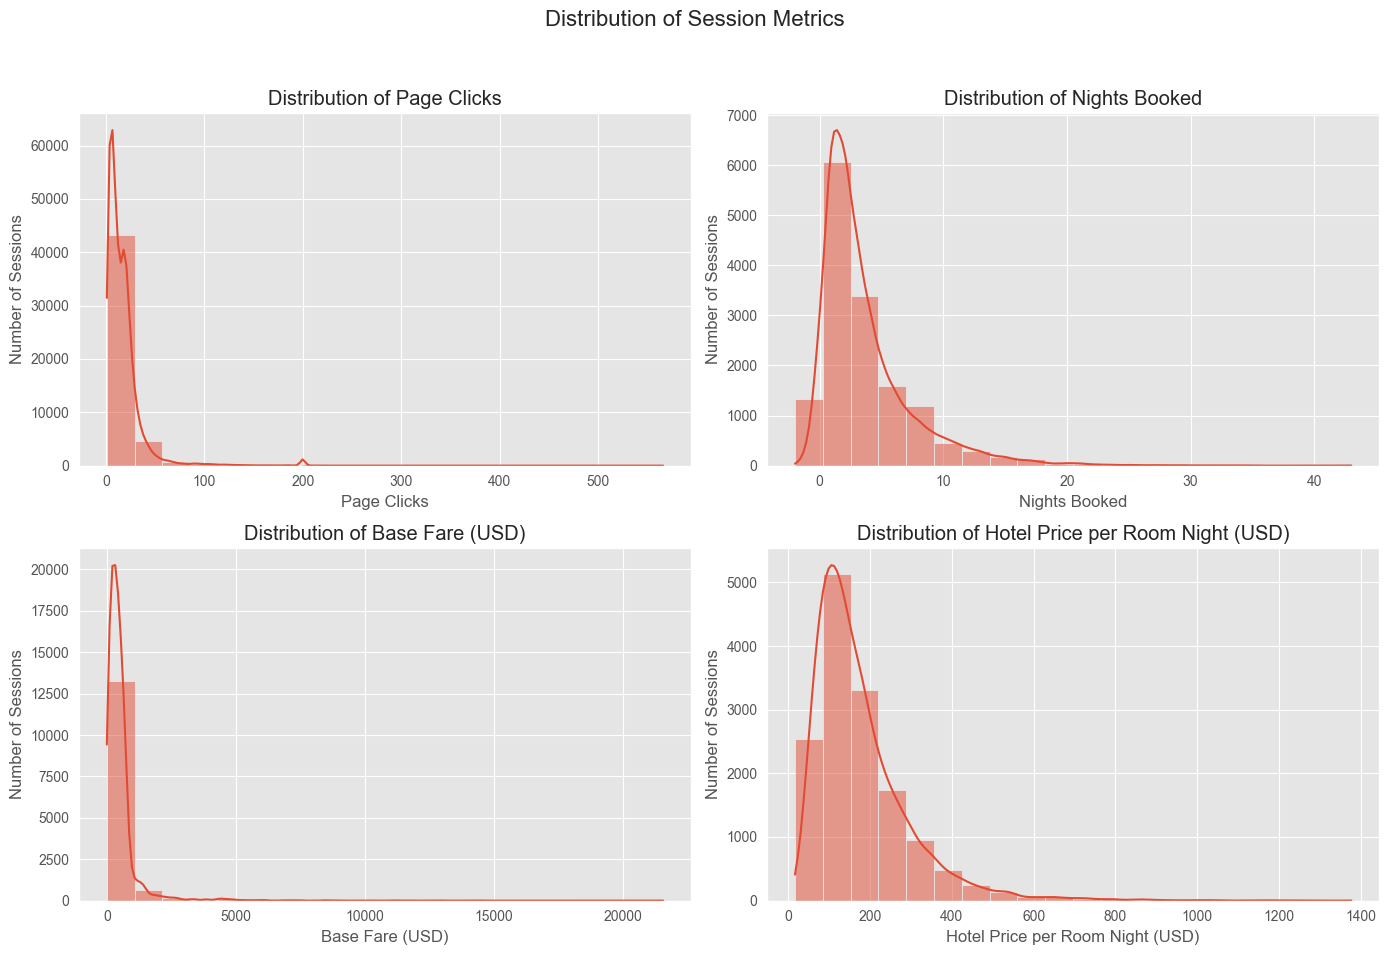

✅ Saved: /Users/claudiatagbo/Masterschool/traveltide/reports/eda/viz/session_distributions.png


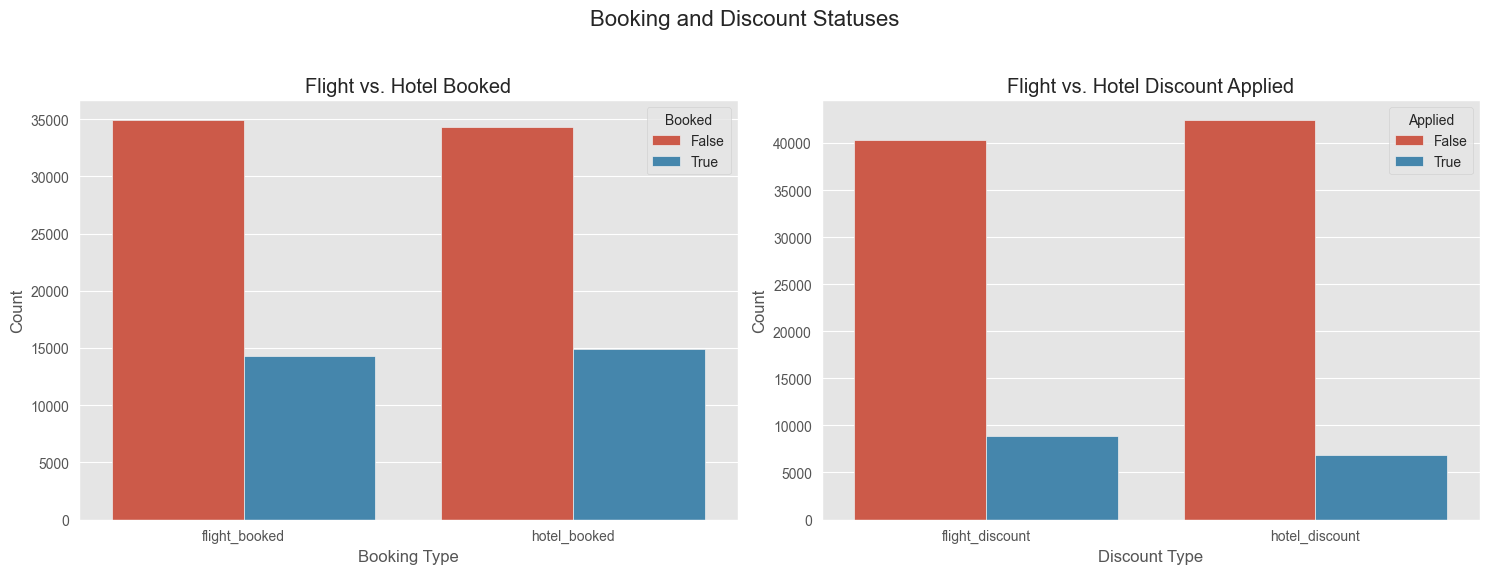

✅ Saved: /Users/claudiatagbo/Masterschool/traveltide/reports/eda/viz/booking_discounts.png


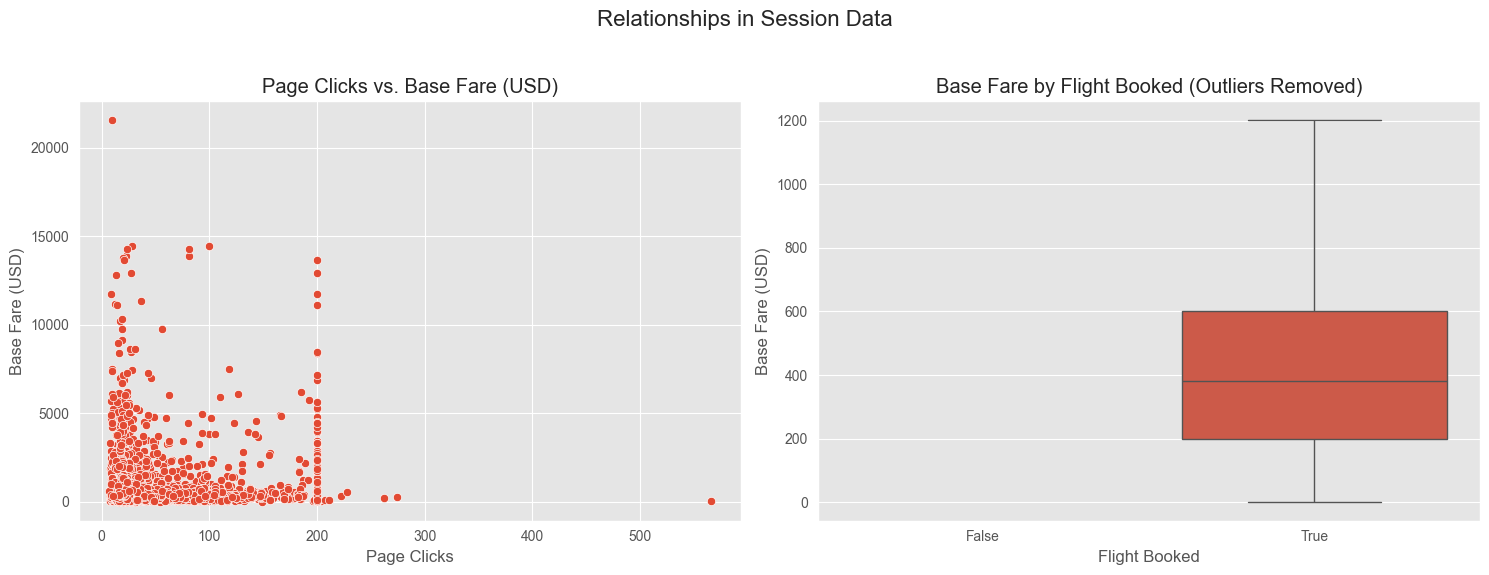

✅ Saved: /Users/claudiatagbo/Masterschool/traveltide/reports/eda/viz/session_relationships.png

🎉 All df_session visualizations successfully generated and saved!


In [162]:
generate_df_session_visualizations(base_sessions)

In [163]:
def create_session_dashboard(df):
    """
    Analysiert das Nutzerverhalten (Sessions) und erstellt ein Dashboard.
    """
    print("\nCreating Session Dashboard...")
    df = df.copy()
    # --- 1. Kundenalter (in Monaten seit Anmeldung) ---
    df = calculate_customer_age(df)
    avg_customer_age = df['customer_age_months'].mean()
    # --- 2. Sitzungslänge / Klicks ---
    avg_clicks = df['page_clicks'].mean()
    clicks_distribution = df['page_clicks']
    # --- Plotting ---
    fig = plt.figure(figsize=(18, 6))
    fig.suptitle('Session Dashboard: User Behavior Analysis', fontsize=18, fontweight='bold')
    gs = fig.add_gridspec(1, 3)
    ax1 = fig.add_subplot(gs[0, 0]) # Avg Clicks
    ax2 = fig.add_subplot(gs[0, 1]) # Avg Customer Age
    ax3 = fig.add_subplot(gs[0, 2]) # Clicks Distribution
    # Plot 1: Average Page Clicks (KPI Card simulation with text)
    ax1.text(0.5, 0.5, f"{avg_clicks:.1f}", ha='center', va='center', fontsize=50, color='teal')
    ax1.set_title("Average Page Clicks per Session", fontsize=14)
    ax1.axis('off')
    # Plot 2: Average Customer Age (KPI Card simulation with text)
    ax2.text(0.5, 0.5, f"{avg_customer_age:.1f}", ha='center', va='center', fontsize=50, color='darkorange')
    ax2.set_title("Average Customer Age (Months Since Signup)", fontsize=14)
    ax2.axis('off')
    # Plot 3: Page Clicks Distribution
    sns.histplot(clicks_distribution.dropna(), bins=20, kde=True, ax=ax3, color='indigo')
    ax3.set_title("Distribution of Page Clicks")
    ax3.set_xlabel("Page Clicks")
    ax3.set_ylabel("Session Count")
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    path = os.path.join(dashboard_path, "session_dashboard.png")
    plt.savefig(path, dpi=300)
    print(f":weißes_häkchen: Session dashboard saved at: {path}")
    plt.show()


Creating Session Dashboard...
:weißes_häkchen: Session dashboard saved at: /Users/claudiatagbo/Masterschool/traveltide/reports/eda/viz/dashboard/session_dashboard.png


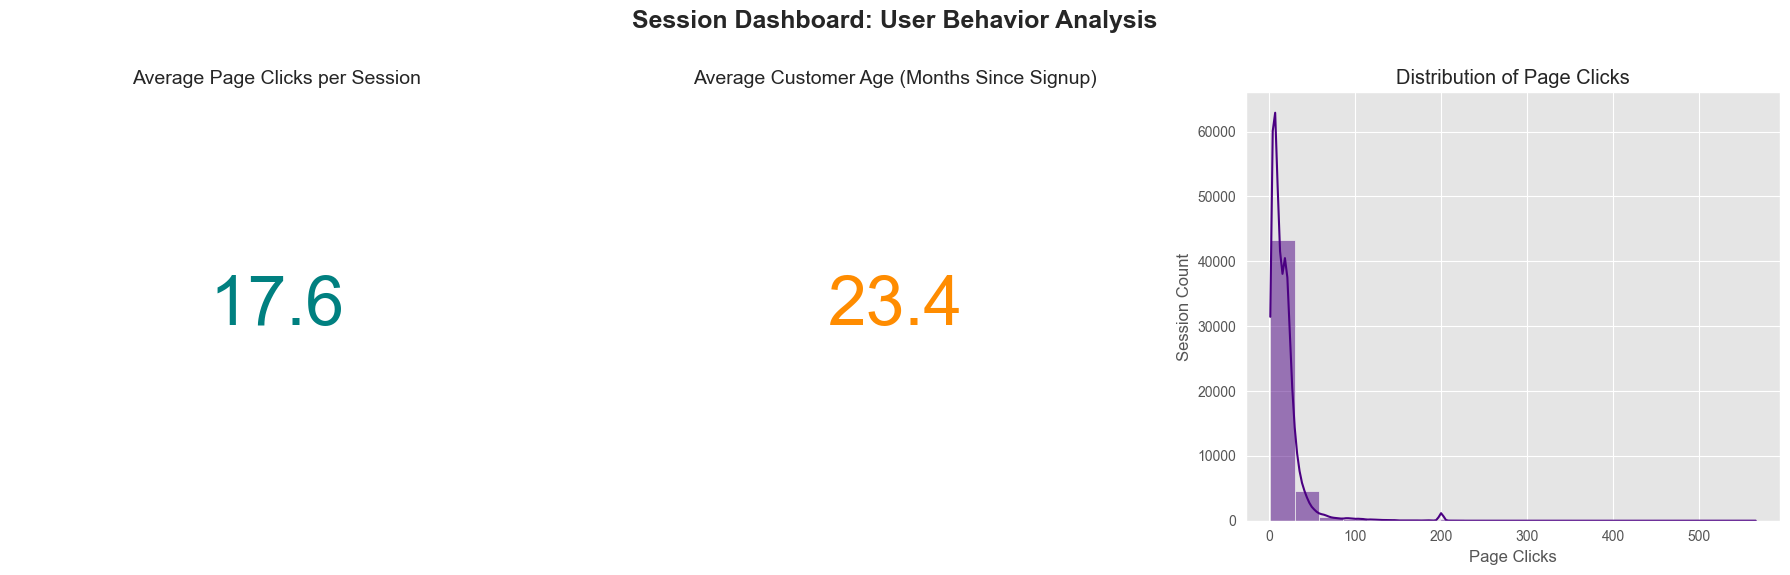

In [164]:
create_session_dashboard(df_sessions_cleaned)

**Nutzeraktivität und Sitzungsverhalten bei TravelTide**
Die durchschnittliche Sitzung umfasst **17,6 Seitenklicks**, was auf eine moderate Interaktion der Nutzer*innen mit der Plattform hinweist. Das durchschnittliche Kundenalter beträgt **23,4 Monate seit der Anmeldung**, was eine stabile und wiederkehrende Nutzerbasis signalisiert. Die Verteilung zeigt, dass über **80 % der Sitzungen weniger als 50 Klicks** umfassen, was typisch für gezielte und effiziente Suchvorgänge ist.




In [165]:
def classify_booking(row):
    """Klassifiziert den Buchungstyp."""
    if row['flight_booked'] and row['hotel_booked']:
        return "Flight + Hotel"
    elif row['flight_booked']:
        return "Flight Only"
    elif row['hotel_booked']:
        return "Hotel Only"
    else:
        return "No Booking"
def create_booking_dashboard(df):
    """
    Analysiert Buchungsdaten (Flüge und Hotels) und erstellt ein Dashboard.
    """
    print("\nCreating Booking Dashboard...")
    df = df.copy()
    # --- 1. Booking Type Classification (wie in Ihrer Vorlage) ---
    # Behalte alle Zeilen, um die "No Booking" Sessions zu zählen
    df['booking_type'] = df.apply(classify_booking, axis=1)
    booking_counts = df['booking_type'].value_counts()
    # --- Vorbereitung für Hotel/Flug-Statistiken ---
    # Berechne die Hotel-Gesamtkosten für die Analyse, da die Kosten über zwei Spalten verteilt sind
    df['hotel_total_price'] = df['hotel_price_per_room_night_usd'] * df['nights']
    # Filtern für detaillierte Buchungsanalysen (Flüge/Hotels)
    df_booked = df[
        (df['flight_booked'] == True) | (df['hotel_booked'] == True)
    ].dropna(subset=['trip_airline', 'hotel_name', 'nights']).copy()
    # --- 2. Top 10 Hotels ---
    hotel_stats = df_booked[df_booked['hotel_booked'] == True].groupby('hotel_name').agg(
        booking_count=('session_id', 'count'),
        avg_nights=('nights', 'mean'),
        # Verwende die berechnete Hotel-Gesamtkosten für den Durchschnittspreis
        avg_price_total=('hotel_total_price', 'mean')
    ).reset_index()
    top_10_hotels = hotel_stats.sort_values(by='booking_count', ascending=False).head(10)
    # --- 3. Airline Seats ---
    airline_seats = df_booked[df_booked['flight_booked'] == True].groupby('trip_airline')['seats'].agg(['count', 'mean']).sort_values(by='count', ascending=False).head(5)
    # --- Plotting ---
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('Booking Dashboard: Flight and Hotel Analysis', fontsize=18, fontweight='bold')
    gs = fig.add_gridspec(3, 2)
    ax1 = fig.add_subplot(gs[0, 0]) # Booking Type Pie
    ax2 = fig.add_subplot(gs[0, 1]) # Top 10 Hotels
    ax3 = fig.add_subplot(gs[1, :]) # Hotel Stats Table
    ax4 = fig.add_subplot(gs[2, 0]) # Airline Bookings
    ax5 = fig.add_subplot(gs[2, 1]) # Seats per Airline
    # Plot 1: Booking Type Distribution
    ax1.pie(
        booking_counts,
        labels=booking_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("coolwarm", len(booking_counts))
    )
    ax1.set_title("Booking Type Distribution (Hotel + Flight Combos)")
    # Plot 2: Top 10 Hotels (Booking Count)
    sns.barplot(x='booking_count', y='hotel_name', data=top_10_hotels, hue='hotel_name', ax=ax2, palette='magma')
    ax2.set_title("Top 10 Most Booked Hotels")
    ax2.set_xlabel("Booking Count")
    ax2.set_ylabel("Hotel Name")
    # Plot 3: Hotel Statistics Table
    ax3.axis('off')
    ax3.set_title("Hotel Performance Metrics (Top 10)")
    # Format the table data
    table_data = top_10_hotels.drop(columns=['booking_count']).round(1)
    table_data = table_data.rename(columns={
        'hotel_name': 'Hotel',
        'avg_nights': 'Avg Nights',
        'avg_price_total': 'Avg Price Total (USD)'
    })
    # Create the table (only if data exists)
    if not table_data.empty:
        table = ax3.table(
            cellText=table_data.values,
            colLabels=table_data.columns,
            loc='center',
            cellLoc='center',
            colColours=['#F5F5F5'] * len(table_data.columns)
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.0, 1.5)
    # Plot 4: Top 5 Airlines (by booking count)
    if not airline_seats.empty:
        sns.barplot(x='count', y=airline_seats.index, data=airline_seats, hue=airline_seats.index, ax=ax4, palette='viridis')
        ax4.set_title("Top 5 Airlines by Booking Count")
        ax4.set_xlabel("Booking Count")
        ax4.set_ylabel("Airline")
    else:
        ax4.set_title("Top 5 Airlines: Keine Daten")
        ax4.axis('off')
    # Plot 5: Average Seats per Airline
    if not airline_seats.empty:
        sns.barplot(x='mean', y=airline_seats.index, data=airline_seats, hue=airline_seats.index,ax=ax5, palette='cividis')
        ax5.set_title("Avg Seats per Booking (Top 5 Airlines)")
        ax5.set_xlabel("Average Seats")
        ax5.set_ylabel("Airline")
    else:
        ax5.set_title("Avg Seats: Keine Daten")
        ax5.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    path = os.path.join(dashboard_path, "booking_dashboard.png")
    plt.savefig(path, dpi=300)
    print(f":weißes_häkchen: Booking dashboard saved at: {path}")
    plt.show()


Creating Booking Dashboard...
:weißes_häkchen: Booking dashboard saved at: /Users/claudiatagbo/Masterschool/traveltide/reports/eda/viz/dashboard/booking_dashboard.png


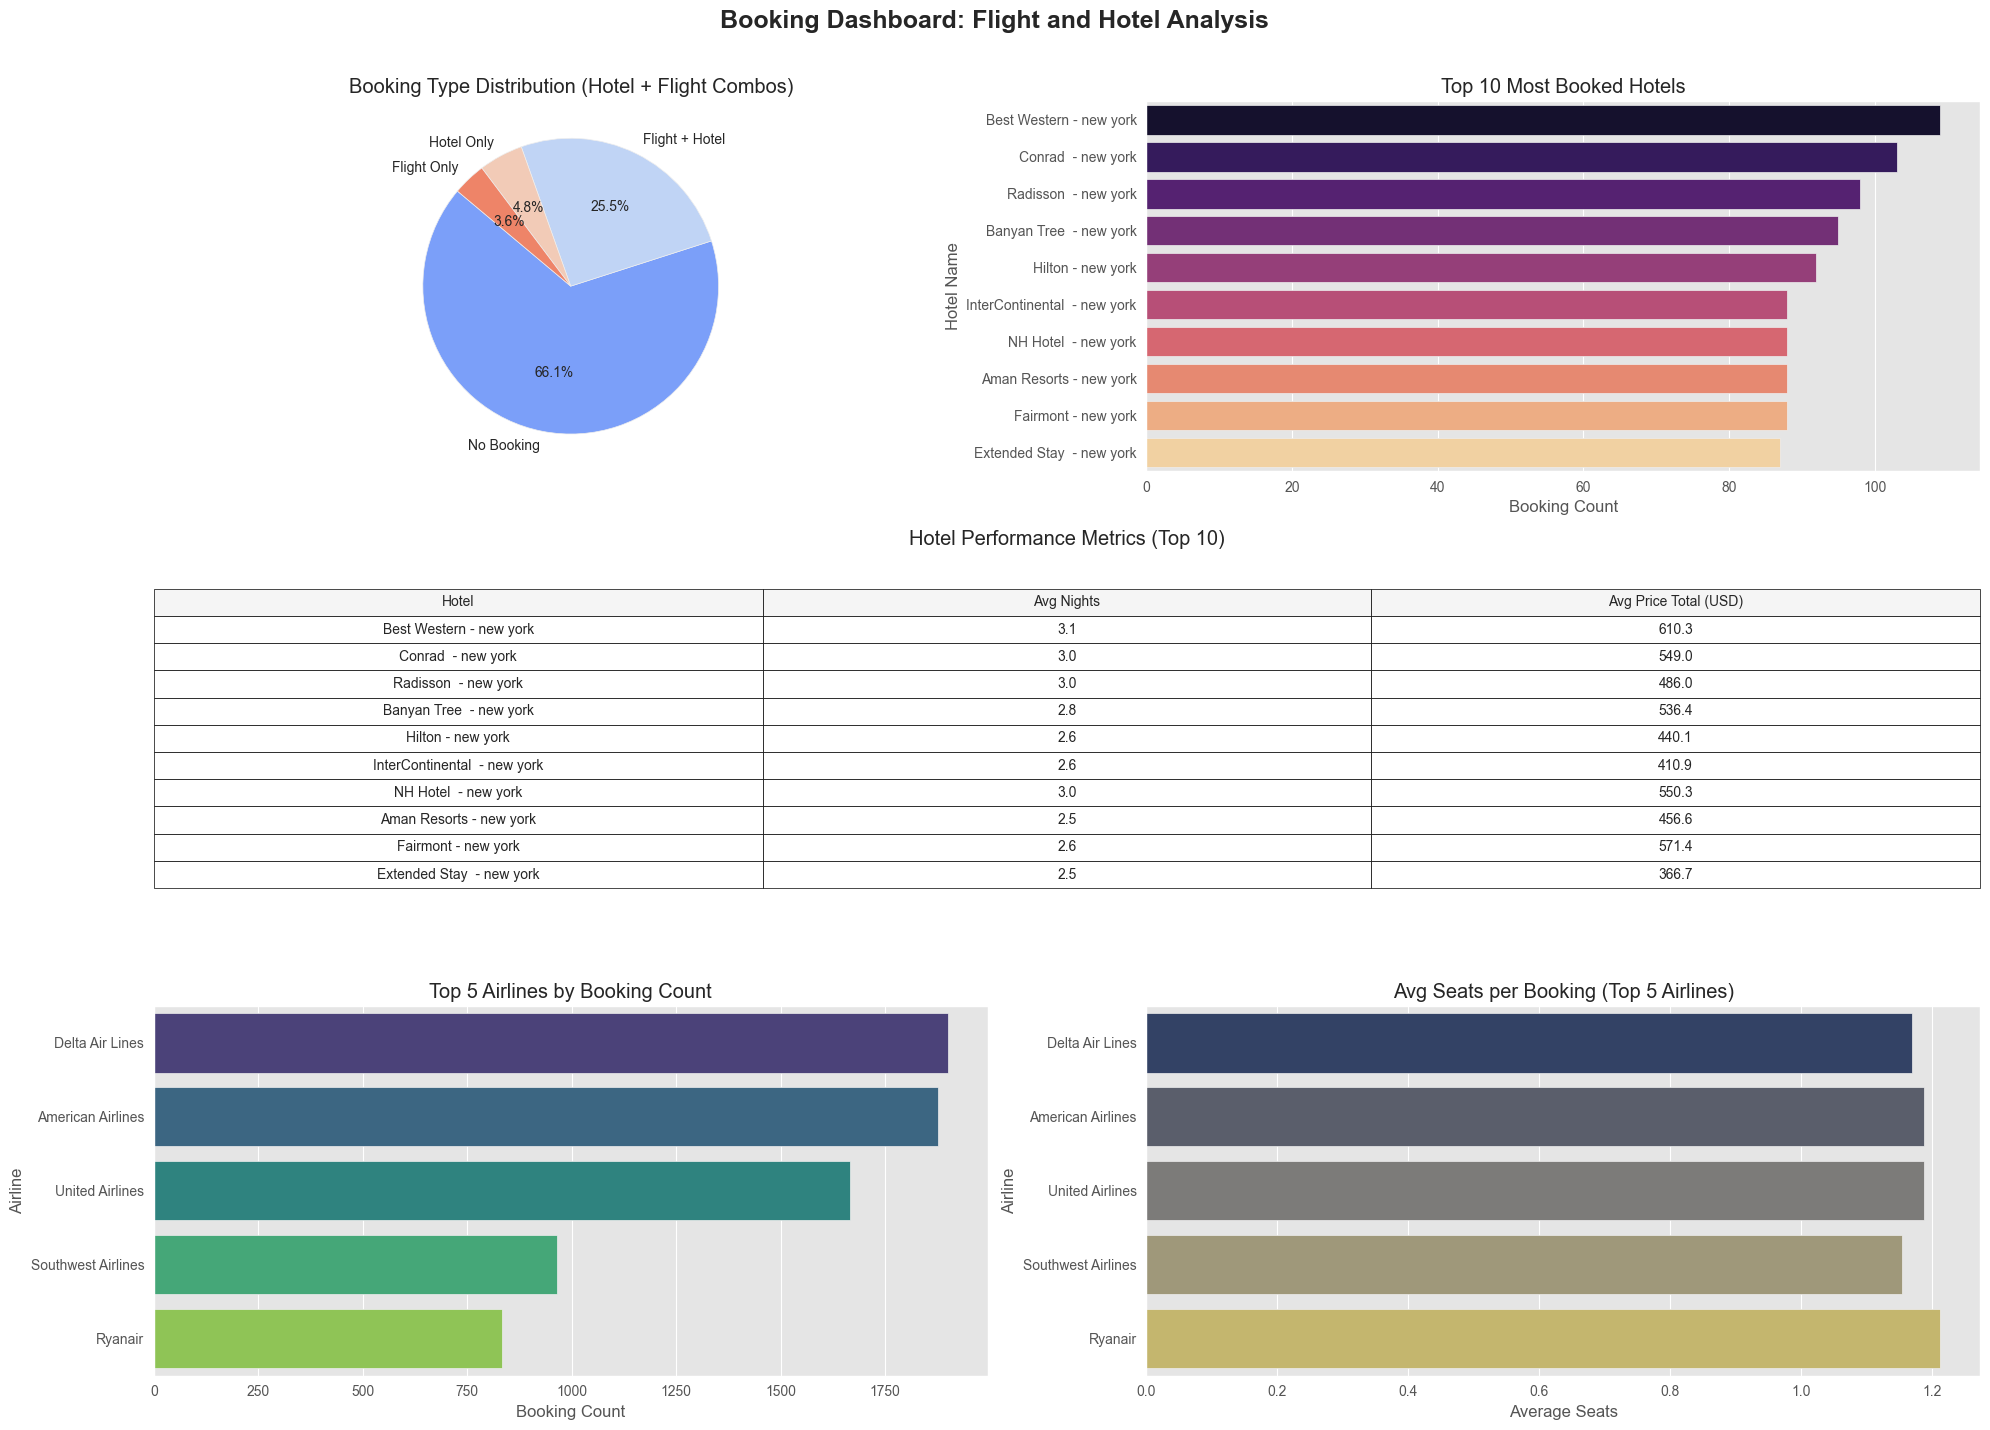

In [166]:
create_booking_dashboard(df_sessions_cleaned)


**Buchungsverhalten und Marktführer im Reise- und Hotelsegment**


Das **Booking-Dashboard** zeigt, dass **66,1 % der Nutzer*innen keine Buchung** abschließen, während **25,5 % kombinierte Flug- und Hotelbuchungen** tätigen – ein Hinweis auf starkes Rechercheverhalten. Unter den Hotels führen **Best Western** und **Conrad New York** mit jeweils rund **100 Buchungen** und einem durchschnittlichen Aufenthalt von **3 Nächten**. Die **durchschnittlichen Hotelpreise** liegen zwischen **370 USD und 610 USD**, wobei New York klar dominiert. Bei den Airlines ist **Delta Air Lines** mit rund **1.800 Buchungen** Spitzenreiter, gefolgt von **American Airlines** und **United Airlines**, mit durchschnittlich **1,2 Sitzen pro Buchung** – typisch für Einzelreisende.


## **Fazit**